## 1. Imports & Setup

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Activation

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow: 2.18.0
GPU Available: False


## 2. Configuration

In [ ]:
# Parameters
DATA_PATH = '../data/5s_data/eth_btc_5s_l2_data.csv'
LOOKAHEAD_STEPS = 60  # 15 minutes at 5-second intervals
SEQUENCE_LENGTH = 100  # 100 steps = 500 seconds lookback
L2_DEPTH_LEVELS = 4    # Number of order book levels to include (1-10)

# Triple Barrier
TAKE_PROFIT_PCT = 0.0015  # +0.2%
STOP_LOSS_PCT = 0.0015    # -0.1% (tighter stop)

print(f"Lookahead: {LOOKAHEAD_STEPS} steps = {LOOKAHEAD_STEPS * 5 / 60:.1f} min")
print(f"Sequence: {SEQUENCE_LENGTH} steps = {SEQUENCE_LENGTH * 5} seconds")

print(f"L2 Depth Levels: {L2_DEPTH_LEVELS}")
print(f"Take Profit: +{TAKE_PROFIT_PCT*100:.1f}%, Stop Loss: -{STOP_LOSS_PCT*100:.1f}%")

Lookahead: 180 steps = 15.0 min
Sequence: 100 steps = 500 seconds
L2 Depth Levels: 4
Take Profit: +0.1%, Stop Loss: -0.1%


## 3. Load Data

In [81]:
# Load CSV
print(f"Loading data from {DATA_PATH}...")
df = pd.read_csv(DATA_PATH)
print(f"Data shape: {df.shape}")

Loading data from ../data/5s_data/eth_btc_5s_l2_data.csv...
Data shape: (324350, 85)
Data shape: (324350, 85)


In [82]:
# Convert timestamp (assume data is already sorted chronologically)
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"\nData shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Check if we have enough data
min_required = LOOKAHEAD_STEPS + SEQUENCE_LENGTH + 100  # ~400 rows minimum
if len(df) < min_required:
    print(f"\n⚠️  WARNING: Insufficient data!")
    print(f"   Current rows: {len(df)}")
    print(f"   Minimum required: ~{min_required}")
    print(f"   Need at least {LOOKAHEAD_STEPS} (lookahead) + {SEQUENCE_LENGTH} (sequence) + buffer")
    print(f"\n   This CSV appears to be a sample/test file.")
    print(f"   Please use a larger dataset for training.")

print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Data shape: (324350, 85)
Date range: 2025-12-21 18:16:07.574055 to 2026-01-09 14:19:35.697691

Columns: ['timestamp', 'ETH_price', 'ETH_volume', 'ETH_bid_price_1', 'ETH_bid_vol_1', 'ETH_ask_price_1', 'ETH_ask_vol_1', 'ETH_bid_price_2', 'ETH_bid_vol_2', 'ETH_ask_price_2', 'ETH_ask_vol_2', 'ETH_bid_price_3', 'ETH_bid_vol_3', 'ETH_ask_price_3', 'ETH_ask_vol_3', 'ETH_bid_price_4', 'ETH_bid_vol_4', 'ETH_ask_price_4', 'ETH_ask_vol_4', 'ETH_bid_price_5', 'ETH_bid_vol_5', 'ETH_ask_price_5', 'ETH_ask_vol_5', 'ETH_bid_price_6', 'ETH_bid_vol_6', 'ETH_ask_price_6', 'ETH_ask_vol_6', 'ETH_bid_price_7', 'ETH_bid_vol_7', 'ETH_ask_price_7', 'ETH_ask_vol_7', 'ETH_bid_price_8', 'ETH_bid_vol_8', 'ETH_ask_price_8', 'ETH_ask_vol_8', 'ETH_bid_price_9', 'ETH_bid_vol_9', 'ETH_ask_price_9', 'ETH_ask_vol_9', 'ETH_bid_price_10', 'ETH_bid_vol_10', 'ETH_ask_price_10', 'ETH_ask_vol_10', 'BTC_price', 'BTC_volume', 'BTC_bid_price_1', 'BTC_bid_vol_1', 'BTC_ask_price_1', 'BTC_ask_vol_1', 'BTC_bid_price_2', 'BTC_bid_vol

,timestamp,ETH_price,ETH_volume,ETH_bid_price_1,ETH_bid_vol_1,ETH_ask_price_1,ETH_ask_vol_1,ETH_bid_price_2,ETH_bid_vol_2,ETH_ask_price_2,...,BTC_ask_price_8,BTC_ask_vol_8,BTC_bid_price_9,BTC_bid_vol_9,BTC_ask_price_9,BTC_ask_vol_9,BTC_bid_price_10,BTC_bid_vol_10,BTC_ask_price_10,BTC_ask_vol_10
0,2025-12-21 18:16:07.574055,2969.90,31338.713240,2969.87,0.003145,2969.88,6.540193,2969.70,0.001000,2969.89,...,87982.00,0.005100,87970.00,4.800000e-03,87983.01,0.002270,87969.71,0.022732,87983.69,0.010000
1,2025-12-21 18:16:12.817972,2969.88,31347.880067,2969.87,0.001523,2969.88,2.115605,2969.56,0.168375,2969.89,...,87987.20,0.051011,87975.76,2.396110e-02,87987.21,0.093420,87974.00,0.004800,87987.64,0.032935
2,2025-12-21 18:16:17.863189,2970.49,31328.356672,2970.58,0.001593,2970.59,0.156291,2970.33,0.168331,2970.60,...,88002.03,0.068000,87978.11,3.409920e-03,88002.04,0.005600,87978.00,0.000066,88002.06,0.093420
3,2025-12-21 18:16:22.807019,2970.22,31338.713240,2970.48,0.001543,2970.49,2.223427,2970.22,0.179197,2970.50,...,87986.53,0.002270,87971.37,5.165000e-03,87988.29,0.002270,87971.02,0.088067,87990.39,0.043124
4,2025-12-21 18:16:27.413885,2971.16,31347.880067,2971.19,0.179178,2971.20,0.471433,2971.05,0.168291,2971.26,...,88000.77,0.022727,87979.76,7.800000e-07,88000.84,0.002276,87979.46,0.009333,88002.37,0.002270


## 4. Use ETH Price

ETH Price Stats:
count    324350.000000
mean       3035.939093
std         103.299168
min        2887.700000
25%        2945.370000
50%        2987.400000
75%        3122.000000
max        3306.330000
Name: price, dtype: float64


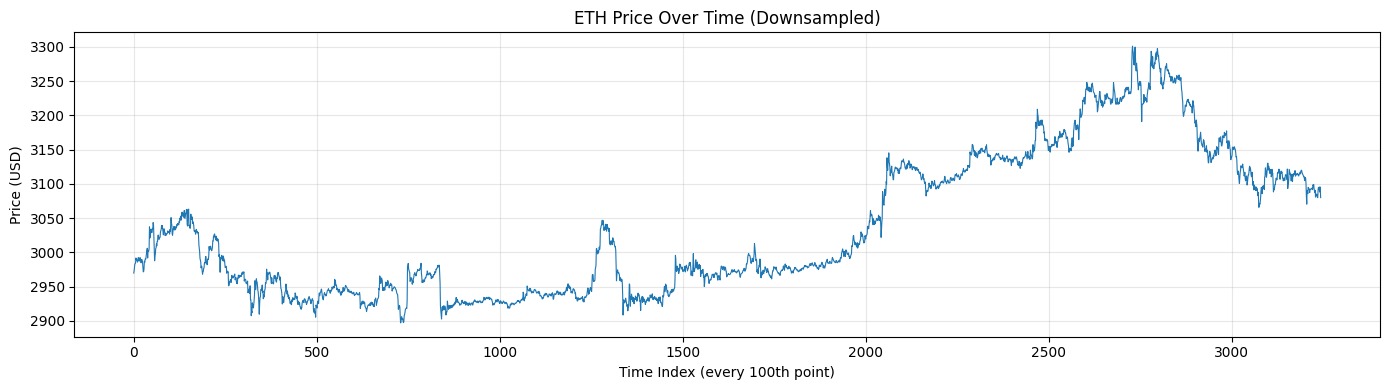

In [83]:
# Use ETH price directly from the combined dataset
df['price'] = df['ETH_price']

print(f"ETH Price Stats:")
print(df['price'].describe())

# Quick visualization
plt.figure(figsize=(14, 4))
plt.plot(df['price'].values[::100], linewidth=0.8)
plt.title('ETH Price Over Time (Downsampled)')
plt.xlabel('Time Index (every 100th point)')
plt.ylabel('Price (USD)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Calculate Rolling Volatility

**Strategy:** Use rolling volatility to make dynamic thresholds that adapt to market conditions.

In [84]:
# Calculate returns and rolling volatility (ATR proxy for snapshots)
df['returns'] = df['price'].pct_change()

# Rolling window of 100 steps (approx 8-10 minutes) to estimate current volatility
df['volatility'] = df['returns'].rolling(window=100).std()

# Fill NaNs (for the first 100 rows) with the mean volatility to avoid errors
df['volatility'] = df['volatility'].fillna(df['volatility'].mean())

# Quick check of what our new targets look like
print(f"Mean Volatility (5s): {df['volatility'].mean():.6f}")
print(f"Dynamic Target (0.5 * Vol): {0.5 * df['volatility'].mean():.6f}")
print(f"Dynamic Target (1.0 * Vol): {1.0 * df['volatility'].mean():.6f}")

print(f"\nVolatility Statistics:")
print(df['volatility'].describe())

Mean Volatility (5s): 0.000148
Dynamic Target (0.5 * Vol): 0.000074
Dynamic Target (1.0 * Vol): 0.000148

Volatility Statistics:
count    324350.000000
mean          0.000148
std           0.000098
min           0.000013
25%           0.000086
50%           0.000121
75%           0.000178
max           0.000890
Name: volatility, dtype: float64


## 6. Dynamic Triple Barrier Labeling

**Key Improvement:** Instead of fixed thresholds (+0.2%/-0.1%), use dynamic barriers based on current market volatility.

- **Upper Barrier:** Price + (Volatility × Multiplier)
- **Lower Barrier:** Price - (Volatility × Multiplier)
- **Multiplier:** Controls sensitivity (e.g., 1.0 = 1 standard deviation move)

In [85]:
import numpy as np

def label_triple_barrier_dynamic(prices, volatilities, lookahead=180, multiplier=1.0):
    """
    Dynamic Triple Barrier Method:
    - Target is determined by current volatility * multiplier
    - Label 1 (BUY): Hit upper barrier (Price + Target) first
    - Label -1 (SELL): Hit lower barrier (Price - Target) first
    - Label 0 (HOLD): Hit neither within lookahead period
    
    Args:
        prices: Array of mid-prices
        volatilities: Array of rolling volatility estimates
        lookahead: Number of steps to look ahead (180 = 15 min)
        multiplier: Volatility multiplier (1.0 = 1 standard deviation)
    """
    n = len(prices)
    labels = np.full(n, np.nan)
    
    print(f"Applying Dynamic Triple Barrier Method (multiplier={multiplier})...")
    for i in tqdm(range(n - lookahead)):
        current_price = prices[i]
        
        # Dynamic threshold for this specific timestamp
        dynamic_threshold = volatilities[i] * np.sqrt(lookahead) * multiplier
        
        # Sanity check: Ensure threshold isn't too tiny (noise)
        if dynamic_threshold < 0.0002:  # Minimum 0.02% move required
            dynamic_threshold = 0.0002
            
        upper_barrier = current_price * (1 + dynamic_threshold)
        lower_barrier = current_price * (1 - dynamic_threshold)
        
        # Look ahead
        future_prices = prices[i+1:i+1+lookahead]
        
        # Check which barrier is hit first
        hit_tp = np.where(future_prices >= upper_barrier)[0]
        hit_sl = np.where(future_prices <= lower_barrier)[0]
        
        if len(hit_tp) > 0 and len(hit_sl) > 0:
            if hit_tp[0] < hit_sl[0]:
                labels[i] = 1  # Upper barrier hit first
            else:
                labels[i] = -1  # Lower barrier hit first
        elif len(hit_tp) > 0:
            labels[i] = 1  # Only upper hit
        elif len(hit_sl) > 0:
            labels[i] = -1  # Only lower hit
        else:
            labels[i] = 0  # Timeout (Hold)
            
    return labels

# Apply dynamic labeling
# Multiplier of 1.0 = barriers at ±1 standard deviation
df['label'] = label_triple_barrier_dynamic(
    df['price'].values,
    df['volatility'].values,
    lookahead=LOOKAHEAD_STEPS,
    multiplier=1.0  # Try 1.0 sigma move
)

print(f"\nLabeling complete!")
print(f"\nLabel distribution (Dynamic Triple Barrier):")
label_counts = df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    if np.isnan(label):
        print(f"  NaN: {count:7d}")
    else:
        label_name = ['SELL', 'HOLD', 'BUY'][int(label) + 1]
        print(f"  {label_name:4s} ({int(label):2d}): {count:7d}")

Applying Dynamic Triple Barrier Method (multiplier=1.0)...


100%|██████████| 324170/324170 [00:01<00:00, 292732.31it/s]


Labeling complete!

Label distribution (Dynamic Triple Barrier):
  SELL (-1):   90664
  HOLD ( 0):  140712
  BUY  ( 1):   92794


## 7. Drop Hold Labels (Label 0)

**Strategy:** Remove neutral/timeout cases to force the model to learn only actionable setups.

In [86]:
# Filter: Keep only BUY (1) and SELL (-1) labels
print(f"Before filtering: {len(df)} rows")

df = df[~df['label'].isna() & (df['label'] != 0)].copy()
df = df.reset_index(drop=True)

print(f"After filtering: {len(df)} rows")
print(f"\nFinal label distribution:")
label_counts = df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    label_name = 'SELL' if label == -1 else 'BUY'
    pct = 100 * count / len(df)
    print(f"  {label_name:4s} ({int(label):2d}): {count:7d} ({pct:.2f}%)")

Before filtering: 324350 rows
After filtering: 183458 rows

Final label distribution:
  SELL (-1):   90664 (49.42%)
  BUY  ( 1):   92794 (50.58%)


## 8. Feature Engineering (Financial Time Series Approach)

**Strategy:** Transform features to be stationary and robust to outliers (whales).

**Key Improvements:**
1. **Log Returns** - Stationary, symmetric, additive
2. **Log Volume Change** - Handles volume spikes
3. **Relative Spread** - Normalized by price
4. **Log-Transformed Depth** - Squashes whale orders
5. **RobustScaler** - Uses median/IQR instead of mean/std

In [87]:
# 1. Momentum & Price Features (ETH)
# Log returns are additive and symmetric -- better for ML than simple % change
df['log_ret'] = np.log(df['price'] / df['price'].shift(1))

# 2. BTC Price Features (for correlation/market context)
df['btc_price'] = df['BTC_price']
df['btc_log_ret'] = np.log(df['btc_price'] / df['btc_price'].shift(1))

# 3. Trade Volume Features (ETH and BTC)
# Log-transform trade volume change
df['log_trade_vol'] = np.log1p(df['ETH_volume'])  # Absolute trade volume
df['log_trade_vol_change'] = df['log_trade_vol'] - df['log_trade_vol'].shift(1)

df['log_btc_vol'] = np.log1p(df['BTC_volume'])
df['log_btc_vol_change'] = df['log_btc_vol'] - df['log_btc_vol'].shift(1)

# 4. Market Structure
df['spread'] = df['ETH_ask_price_1'] - df['ETH_bid_price_1']

# 5. Order Flow Imbalance (OFI) - using order book depth
df['bid_vol_1_shift'] = df['ETH_bid_vol_1'].shift(1)
df['ask_vol_1_shift'] = df['ETH_ask_vol_1'].shift(1)
df['OFI'] = (df['ETH_bid_vol_1'] - df['bid_vol_1_shift']) - (df['ETH_ask_vol_1'] - df['ask_vol_1_shift'])

# 6. Log-Transform Order Book Depth Volumes (Squash the "Whales")
# Only transform bid/ask volumes (order book depth), NOT trade volume
depth_vol_cols = [c for c in df.columns if c.startswith('ETH_') and ('bid_vol' in c or 'ask_vol' in c) and 'shift' not in c]
print(f"Log-transforming {len(depth_vol_cols)} order book depth columns: {depth_vol_cols[:4]}... (showing first 4)")

for col in depth_vol_cols:
    df[f'log_{col}'] = np.log1p(df[col])  # log1p = log(1 + x) to handle zeros

# Drop temporary shift columns and NaNs
df = df.drop(columns=['bid_vol_1_shift', 'ask_vol_1_shift', 'log_trade_vol', 'log_btc_vol'])  # Keep log_trade_vol_change and log_btc_vol_change
df = df.dropna().reset_index(drop=True)

print(f"\nAfter feature engineering: {len(df)} rows")
print(f"\nKey feature statistics:")
print(df[['log_ret', 'log_trade_vol_change', 'OFI']].describe())


Log-transforming 20 order book depth columns: ['ETH_bid_vol_1', 'ETH_ask_vol_1', 'ETH_bid_vol_2', 'ETH_ask_vol_2']... (showing first 4)

After feature engineering: 167831 rows

Key feature statistics:

After feature engineering: 167831 rows

Key feature statistics:
            log_ret  log_trade_vol_change            OFI
count  1.678310e+05         167831.000000  167831.000000
mean  -9.817815e-08              0.000005       0.069727
std    2.313231e-04              0.005475      66.806431
min   -9.389121e-03             -0.325124   -7399.723301
25%   -4.108558e-05             -0.000014      -0.896243
50%    0.000000e+00              0.000000       0.000013
75%    4.079973e-05              0.000083       0.899587
max    7.905924e-03              0.260238    7398.463916
            log_ret  log_trade_vol_change            OFI
count  1.678310e+05         167831.000000  167831.000000
mean  -9.817815e-08              0.000005       0.069727
std    2.313231e-04              0.005475      66.

## 9. Select Features & Labels

In [88]:
# Feature columns - using stationary and robust transformations
feature_cols = [
    'log_ret',                # ETH price momentum (stationary)
    'log_trade_vol_change',   # ETH trade volume momentum  
    'btc_log_ret',            # BTC price momentum (market context)
    'log_btc_vol_change',     # BTC trade volume momentum
    'OFI',                    # Order flow imbalance
]

# Add log-transformed order book depth based on L2_DEPTH_LEVELS config
for i in range(1, L2_DEPTH_LEVELS + 1):
    feature_cols.extend([f'log_ETH_bid_vol_{i}', f'log_ETH_ask_vol_{i}'])

print(f"Using {L2_DEPTH_LEVELS} levels of L2 order book data")
print(f"Total features: {len(feature_cols)}")

X = df[feature_cols].values
y = df['label'].values

print(f"Feature matrix X: {X.shape}")
print(f"Label vector y: {y.shape}")
print(f"\nFeatures ({len(feature_cols)} total):")
for i, feat in enumerate(feature_cols):
    print(f"  {i+1:2d}. {feat}")
    
# Check for any remaining NaNs or Infs
if np.isnan(X).any() or np.isinf(X).any():
    print(f"\n⚠️  WARNING: Found NaN or Inf in features!")
    print(f"   NaN count: {np.isnan(X).sum()}")
    print(f"   Inf count: {np.isinf(X).sum()}")
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"   ✓ Cleaned")
else:
    print(f"\n✓ No NaN or Inf values")

Using 4 levels of L2 order book data
Total features: 13
Feature matrix X: (167831, 13)
Label vector y: (167831,)

Features (13 total):
   1. log_ret
   2. log_trade_vol_change
   3. btc_log_ret
   4. log_btc_vol_change
   5. OFI
   6. log_ETH_bid_vol_1
   7. log_ETH_ask_vol_1
   8. log_ETH_bid_vol_2
   9. log_ETH_ask_vol_2
  10. log_ETH_bid_vol_3
  11. log_ETH_ask_vol_3
  12. log_ETH_bid_vol_4
  13. log_ETH_ask_vol_4

✓ No NaN or Inf values


## 10. Create Sequences

In [89]:
def create_sequences(X, y, sequence_length):
    """
    Create sliding window sequences.
    
    Returns:
        X_seq: (n_sequences, sequence_length, n_features)
        y_seq: (n_sequences,)
    """
    X_seq, y_seq = [], []
    
    print(f"Creating sequences with length {sequence_length}...")
    for i in tqdm(range(sequence_length, len(X))):
        X_seq.append(X[i - sequence_length:i])
        y_seq.append(y[i])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
X_sequences, y_sequences = create_sequences(X, y, SEQUENCE_LENGTH)

print(f"\nSequence shapes:")
print(f"  X_sequences: {X_sequences.shape}  # (n_sequences, sequence_length, n_features)")
print(f"  y_sequences: {y_sequences.shape}  # (n_sequences,)")

Creating sequences with length 100...


100%|██████████| 167731/167731 [00:00<00:00, 3287421.63it/s]




Sequence shapes:
  X_sequences: (167731, 100, 13)  # (n_sequences, sequence_length, n_features)
  y_sequences: (167731,)  # (n_sequences,)


## 11. Train/Validation Split (Chronological)

In [90]:
# 80/20 split (chronological - no shuffling!)
split_idx = int(0.8 * len(X_sequences))

X_train = X_sequences[:split_idx]
y_train = y_sequences[:split_idx]

X_val = X_sequences[split_idx:]
y_val = y_sequences[split_idx:]

print(f"Train/Val Split (Chronological):")
print(f"  Train: {X_train.shape[0]:7d} sequences")
print(f"  Val:   {X_val.shape[0]:7d} sequences")

Train/Val Split (Chronological):
  Train:  134184 sequences
  Val:     33547 sequences


## 12. Robust Scaling (Outlier-Resistant)

**Why RobustScaler?**
- Uses **median** and **IQR** instead of mean/std
- Resistant to extreme outliers (whale orders, flash crashes)
- Better for crypto's "fat-tailed" distributions
- Preserves relative differences without being thrown off by rare events

In [91]:
from sklearn.preprocessing import RobustScaler

# RobustScaler (fit on train only)
scaler = RobustScaler()

# Reshape to 2D, fit, transform, reshape back to 3D
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_2d)

X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

print(f"RobustScaler applied:")
print(f"  Train median: {np.median(X_train_scaled):.6f}, IQR: {np.percentile(X_train_scaled, 75) - np.percentile(X_train_scaled, 25):.6f}")
print(f"  Val median:   {np.median(X_val_scaled):.6f}, IQR: {np.percentile(X_val_scaled, 75) - np.percentile(X_val_scaled, 25):.6f}")
print(f"\n✓ Features scaled using RobustScaler (resistant to outliers)")

RobustScaler applied:
  Train median: 0.000000, IQR: 0.981230
  Train median: 0.000000, IQR: 0.981230
  Val median:   0.000000, IQR: 0.954633

✓ Features scaled using RobustScaler (resistant to outliers)
  Val median:   0.000000, IQR: 0.954633

✓ Features scaled using RobustScaler (resistant to outliers)


## 13. Convert Labels to Categorical

In [92]:
# Map labels: -1 -> 0 (SELL), 1 -> 1 (BUY)
# For binary classification with 2 classes
y_train_mapped = ((y_train + 1) / 2).astype(int)  # -1 -> 0, 1 -> 1
y_val_mapped = ((y_val + 1) / 2).astype(int)

y_train_cat = keras.utils.to_categorical(y_train_mapped, num_classes=2)
y_val_cat = keras.utils.to_categorical(y_val_mapped, num_classes=2)

print(f"Labels converted to categorical:")
print(f"  y_train_cat: {y_train_cat.shape}")
print(f"  y_val_cat: {y_val_cat.shape}")
print(f"\nClass distribution in train:")
unique, counts = np.unique(y_train_mapped, return_counts=True)
for cls, cnt in zip(unique, counts):
    cls_name = 'SELL' if cls == 0 else 'BUY'
    print(f"  {cls_name}: {cnt} ({100*cnt/len(y_train_mapped):.1f}%)")

Labels converted to categorical:
  y_train_cat: (134184, 2)
  y_val_cat: (33547, 2)

Class distribution in train:
  SELL: 64852 (48.3%)
  BUY: 69332 (51.7%)


## 14. Build Simple CNN Model

In [93]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D, BatchNormalization, Activation, Input, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_cnn_lstm_model(sequence_length, n_features, n_classes=2):
    model = Sequential(name="DeepLOB_Hybrid")
    
    # --- BLOCK 1: LOCAL FEATURE EXTRACTION (CNN) ---
    # Captures short-term patterns (e.g., "rapid bid filling")
    # We use 64 filters to catch various micro-shapes
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', input_shape=(sequence_length, n_features)))
    model.add(BatchNormalization())  # Stabilizes training (prevents "model collapse")
    model.add(Activation('relu'))
    
    model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # Downsample: Reduce sequence length from 100 -> 50
    # This condenses information so the LSTM doesn't get overwhelmed
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25)) # Moderate dropout to prevent overfitting
    
    # --- BLOCK 2: TEMPORAL MEMORY (LSTM) ---
    # Captures long-term context (e.g., "selling pressure has been building for 5 mins")
    # Return Sequences=True lets us stack LSTMs
    model.add(LSTM(64, return_sequences=True)) 
    model.add(Dropout(0.25))
    
    # Final LSTM layer condenses everything into a single "State Vector"
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.25))
    
    # --- BLOCK 3: DECISION HEAD ---
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    # Use a lower learning rate for LSTMs (1e-4 is standard)
    optimizer = Adam(learning_rate=1e-4)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Re-build
model = build_cnn_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    n_features=X_train_scaled.shape[2],
    n_classes=2
)

print(f"CNN-LSTM Hybrid Built. Params: {model.count_params():,}")

CNN-LSTM Hybrid Built. Params: 83,746


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [94]:
print("Model with Regularization Built.")
print("Model Architecture:")
print("="*60)
model.summary()
print("="*60)
print(f"Total parameters: {model.count_params():,}")

Model with Regularization Built.
Model Architecture:


Model: "DeepLOB_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 100, 64)        │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,746 (327.13 KB)

 Trainable params: 83,426 (325.88 KB)

 Non-trainable params: 320 (1.25 KB)

Total parameters: 83,746


## 15. Train Model

In [95]:
# Callback: Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Training
BATCH_SIZE = 64
EPOCHS = 50

print(f"Training parameters:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Early stopping patience: 10")
print(f"\nStarting training...\n")

history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)

Training parameters:
  Batch size: 64
  Max epochs: 50
  Early stopping patience: 10

Starting training...

Epoch 1/50
Epoch 1/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 103s 48ms/step - accuracy: 0.5096 - loss: 0.7355 - val_accuracy: 0.5381 - val_loss: 0.6911
Epoch 2/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 103s 48ms/step - accuracy: 0.5096 - loss: 0.7355 - val_accuracy: 0.5381 - val_loss: 0.6911
Epoch 2/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 105s 50ms/step - accuracy: 0.5697 - loss: 0.6815 - val_accuracy: 0.5587 - val_loss: 0.6937
Epoch 3/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 105s 50ms/step - accuracy: 0.5697 - loss: 0.6815 - val_accuracy: 0.5587 - val_loss: 0.6937
Epoch 3/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 107s 51ms/step - accuracy: 0.6302 - loss: 0.6442 - val_accuracy: 0.5480 - val_loss: 0.7198
Epoch 4/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 107s 51ms/step - accuracy: 0.6302 - loss: 0.6442 - val_accuracy: 0.5480 - val_loss: 0.7198
Epoch 4/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 107s 51ms/step - accuracy: 0.6774 - loss:

## 16. Training History

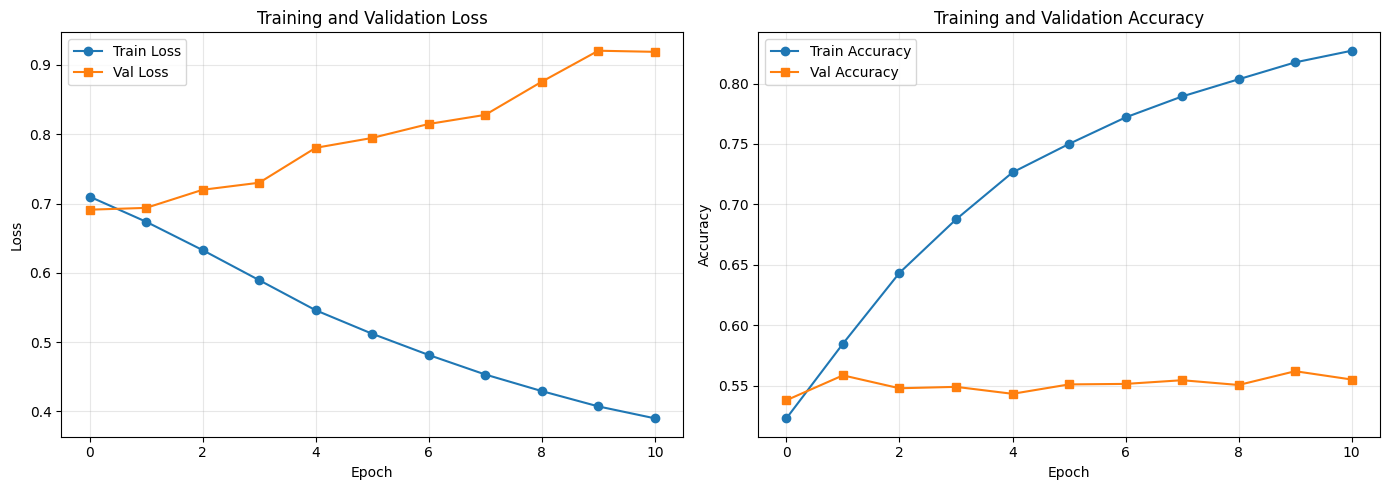

Best epoch: 1
  Val Loss: 0.6911
  Val Accuracy: 0.5381


In [96]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Best epoch
best_epoch = np.argmin(history.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"  Val Loss: {history.history['val_loss'][best_epoch]:.4f}")
print(f"  Val Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")

## 17. Evaluate Model

In [97]:
# Evaluate on validation set
print("Evaluating on validation set...\n")
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val_cat, verbose=0)

print(f"Validation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_accuracy:.4f}")

# Get predictions
y_pred_probs = model.predict(X_val_scaled, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

print(f"\nPrediction distribution:")
unique, counts = np.unique(y_pred, return_counts=True)
for cls, cnt in zip(unique, counts):
    cls_name = 'SELL' if cls == 0 else 'BUY'
    print(f"  {cls_name}: {cnt} ({100*cnt/len(y_pred):.1f}%)")

Evaluating on validation set...

Validation Results:
  Loss: 0.6911
  Accuracy: 0.5381
Validation Results:
  Loss: 0.6911
  Accuracy: 0.5381

Prediction distribution:
  SELL: 14536 (43.3%)
  BUY: 19011 (56.7%)

Prediction distribution:
  SELL: 14536 (43.3%)
  BUY: 19011 (56.7%)


## 18. Confusion Matrix

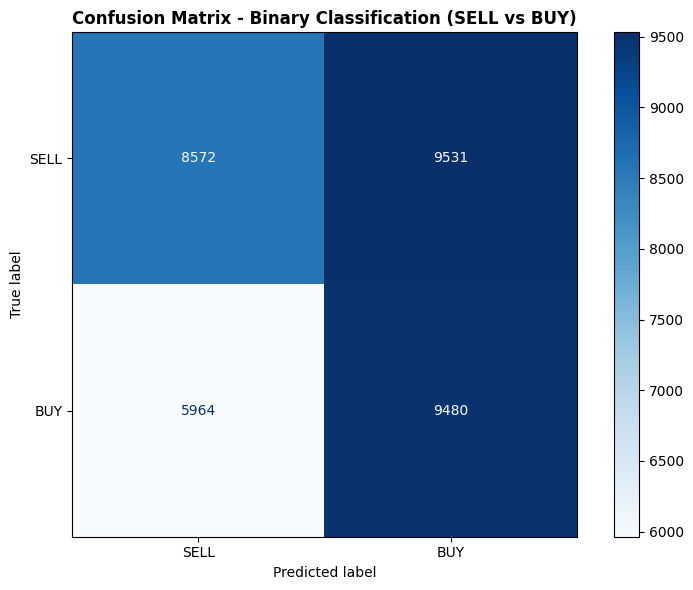


Confusion Matrix:
[[8572 9531]
 [5964 9480]]

Rows = True labels, Cols = Predicted labels


In [98]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['SELL', 'BUY']

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Binary Classification (SELL vs BUY)', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)
print("\nRows = True labels, Cols = Predicted labels")

## 19. Classification Report

In [99]:
# Detailed classification report
print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Per-class accuracy
print(f"\nPer-Class Accuracy:")
for i, cls_name in enumerate(class_names):
    mask = y_true == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == i).sum() / mask.sum()
        print(f"  {cls_name:4s}: {acc:.4f}")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        SELL     0.5897    0.4735    0.5253     18103
         BUY     0.4987    0.6138    0.5503     15444

    accuracy                         0.5381     33547
   macro avg     0.5442    0.5437    0.5378     33547
weighted avg     0.5478    0.5381    0.5368     33547


Per-Class Accuracy:
  SELL: 0.4735
  BUY : 0.6138


## 20. Save Model

In [100]:
# Create models directory if it doesn't exist
import os
import json
os.makedirs('models', exist_ok=True)

# Calculate current model's per-class accuracy
sell_mask = y_true == 0
buy_mask = y_true == 1

current_sell_acc = (y_pred[sell_mask] == 0).sum() / sell_mask.sum() if sell_mask.sum() > 0 else 0
current_buy_acc = (y_pred[buy_mask] == 1).sum() / buy_mask.sum() if buy_mask.sum() > 0 else 0
current_avg_class_acc = (current_sell_acc + current_buy_acc) / 2

print("\n" + "="*60)
print("MODEL SAVING LOGIC")
print("="*60)
print(f"\nCurrent Model Performance:")
print(f"  SELL Accuracy: {current_sell_acc:.4f}")
print(f"  BUY Accuracy:  {current_buy_acc:.4f}")
print(f"  Avg Class Acc: {current_avg_class_acc:.4f}")
print()

# Check if best model exists
best_metrics_path = 'models/best_model_metrics.json'
should_save = False

if os.path.exists(best_metrics_path):
    # Load previous best metrics
    with open(best_metrics_path, 'r') as f:
        best_metrics = json.load(f)
    
    prev_sell_acc = best_metrics['sell_accuracy']
    prev_buy_acc = best_metrics['buy_accuracy']
    prev_avg_acc = best_metrics['avg_class_accuracy']
    
    print(f"Previous Best Model Performance:")
    print(f"  SELL Accuracy: {prev_sell_acc:.4f}")
    print(f"  BUY Accuracy:  {prev_buy_acc:.4f}")
    print(f"  Avg Class Acc: {prev_avg_acc:.4f}")
    print()
    
    # Check if current model is better (using average of both class accuracies)
    if current_avg_class_acc > prev_avg_acc:
        should_save = True
        improvement = (current_avg_class_acc - prev_avg_acc) * 100
        print(f"✓ NEW BEST MODEL! Improvement: +{improvement:.2f}%")
    else:
        decline = (prev_avg_acc - current_avg_class_acc) * 100
        print(f"✗ Not saving. Current model is {decline:.2f}% worse than best.")
else:
    # No previous model exists
    should_save = True
    print("No previous best model found. Saving current model as best.")

print()

if should_save:
    # Save model
    model.save('models/best_model.keras')
    print("✓ Model saved: models/best_model.keras")
    
    # Save scaler
    import joblib
    joblib.dump(scaler, 'models/best_scaler.pkl')
    print("✓ Scaler saved: models/best_scaler.pkl")
    
    # Save metrics
    metrics = {
        'sell_accuracy': float(current_sell_acc),
        'buy_accuracy': float(current_buy_acc),
        'avg_class_accuracy': float(current_avg_class_acc),
        'overall_accuracy': float(val_accuracy),
        'val_loss': float(val_loss),
        'timestamp': pd.Timestamp.now().isoformat(),
        'lookahead_steps': LOOKAHEAD_STEPS,
        'sequence_length': SEQUENCE_LENGTH
    }
    
    with open(best_metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print("✓ Metrics saved: models/best_model_metrics.json")
    print("\n🎉 Model successfully saved as new best!")
else:
    print("⏭️  Skipping save. Previous model remains as best.")

print("\n" + "="*60)
print("NOTEBOOK COMPLETE")
print("="*60)
print(f"\nCurrent Model Summary:")
print(f"  Architecture: CNN-LSTM Hybrid")
print(f"  Features: {len(feature_cols)} (log returns, volumes, spread, OFI)")
print(f"  Labeling: Dynamic Triple Barrier (volatility-based)")
print(f"  Classes: Binary (SELL vs BUY, no HOLD)")
print(f"  Sequence Length: {SEQUENCE_LENGTH} steps")
print(f"  Val Accuracy: {val_accuracy:.4f}")
print(f"  Avg Class Accuracy: {current_avg_class_acc:.4f}")


MODEL SAVING LOGIC

Current Model Performance:
  SELL Accuracy: 0.4735
  BUY Accuracy:  0.6138
  Avg Class Acc: 0.5437

Previous Best Model Performance:
  SELL Accuracy: 0.9859
  BUY Accuracy:  0.5581
  Avg Class Acc: 0.7720

✗ Not saving. Current model is 22.84% worse than best.

⏭️  Skipping save. Previous model remains as best.

NOTEBOOK COMPLETE

Current Model Summary:
  Architecture: CNN-LSTM Hybrid
  Features: 13 (log returns, volumes, spread, OFI)
  Labeling: Dynamic Triple Barrier (volatility-based)
  Classes: Binary (SELL vs BUY, no HOLD)
  Sequence Length: 100 steps
  Val Accuracy: 0.5381
  Avg Class Accuracy: 0.5437
